# Instantiate compute environment

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from scipy import stats
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

# Read Data

In [3]:
df = pd.read_csv('data/processed/alles02.csv', header = 0)
df = df.drop(['Unnamed: 0'], axis=1)
df.sample(5).head()

,SMILES,InChI,EndPt,ReadyBiodeg
510,Cc1cccc(c1C)[N+](=O)[O-],FVHAWXWFPBPFOS-UHFFFAOYSA-N,NRB,0
1743,CCCCCCCCCCCCCCCCCCCCCCC,FIGVVZUWCLSUEI-UHFFFAOYSA-N,RB,1
631,CCCCCCCCCCCC(=O)OC[C@@H](O)[C@H]1OC[C@H](O)[C@...,LWZFANDGMFTDAV-BURFUSLBSA-N,RB,1
1086,CCCCCCCCCc1ccc(OCCOCCOCCOCCOCCOCCOS(=O)(=O)O)cc1,DCVXQTZKGDLQBC-UHFFFAOYSA-N,NRB,0
490,COC(C)(C)CC(=O)C,KOKPBCHLPVDQTK-UHFFFAOYSA-N,NRB,0


# Calculate features

In [4]:
nms = [x[0] for x in Descriptors._descList]
calc = MoleculeDescriptors.MolecularDescriptorCalculator(nms)
for i in range(len(df)):
    try:
        descrs = calc.CalcDescriptors(Chem.MolFromSmiles(df.iloc[i, 0]))
        for x in range(len(descrs)):
            df.at[i, str(nms[x])] = descrs[x]
    except:
        for x in range(len(descrs)):
            df.at[i, str(nms[x])] = 'NaN'   
            
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()
df = df.reset_index(drop=True)

In [5]:
df.sample(5).head()

,SMILES,InChI,EndPt,ReadyBiodeg,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
1067,Clc1ccc(OCOCC#CI)cc1,KQLBUIOMHNFZMD-UHFFFAOYSA-N,NRB,0,5.708326,0.201342,5.708326,0.201342,0.366993,322.529,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
447,Cc1ccccc1S(=O)(=O)O,LBLYYCQCTBFVLH-UHFFFAOYSA-N,NRB,0,10.609259,-4.033495,10.609259,0.027778,0.648272,172.205,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
850,CC\C=C/CCO,UFLHIIWVXFIJGU-ARJAWSKDSA-N,RB,1,8.241633,0.274306,8.241633,0.274306,0.530402,100.161,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
205,OC(=O)c1ccc(nc1)C(O)=O,LVPMIMZXDYBCDF-UHFFFAOYSA-N,NRB,0,10.294654,-1.174131,10.294654,0.027778,0.668250,167.120,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1530,CCCCOC(=O)COC(=O)c1ccccc1C(=O)OCCCC,GOJCZVPJCKEBQV-UHFFFAOYSA-N,RB,1,12.096565,-0.758812,12.096565,0.069775,0.370922,336.384,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


In [6]:
df.shape

(2043, 204)

# Apply property filters
Taken from:
* "Designing screens: how to make your hits a hit" W. Patrick Walters & Mark Namchuk, *Nature Reviews Drug Discovery*, **2**, 259 - 266 (2003)  
* "Streamlining lead discovery by aligning *in silico* and high-throughput screening" John W. Davies, Meir Glick, Jeremy L. Jenkins, *Current Opinion in Chemical Biology*, **10**(4), 343 - 351 (2006)

In [7]:
# molecular weight
dfFiltered = df[df['MolWt'] <= 700]
dfFiltered.shape

(2011, 204)

In [8]:
# heavy atom count
dfFiltered = dfFiltered[dfFiltered['HeavyAtomCount'] <= 50]
dfFiltered.shape

(2010, 204)

In [9]:
# number rotatable bonds
dfFiltered = dfFiltered[dfFiltered['NumRotatableBonds'] <= 12]
dfFiltered.shape

(1844, 204)

In [10]:
# H-bond donors
dfFiltered = dfFiltered[dfFiltered['NumHDonors'] <= 5]
dfFiltered.shape

(1831, 204)

In [11]:
# H-bond acceptors
dfFiltered = dfFiltered[dfFiltered['NumHAcceptors'] <= 10]
dfFiltered.shape

(1820, 204)

In [12]:
# hydrophobicity
dfFiltered = dfFiltered[dfFiltered['MolLogP'] <= 7.5]
dfFiltered.shape

(1802, 204)

In [13]:
# hydrophobicity
dfFiltered = dfFiltered[dfFiltered['MolLogP'] >= -5.0]
dfFiltered.shape

(1802, 204)

In [14]:
# Function to calculate correlation coefficient between two arrays
def corr(x, y, **kwargs):
    
    # Calculate the value
    coef = np.corrcoef(x, y)[0][1]
    # Make the label
    label = r'$\rho$ = ' + str(round(coef, 2))
    
    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy = (0.2, 0.95), size = 20, xycoords = ax.transAxes)

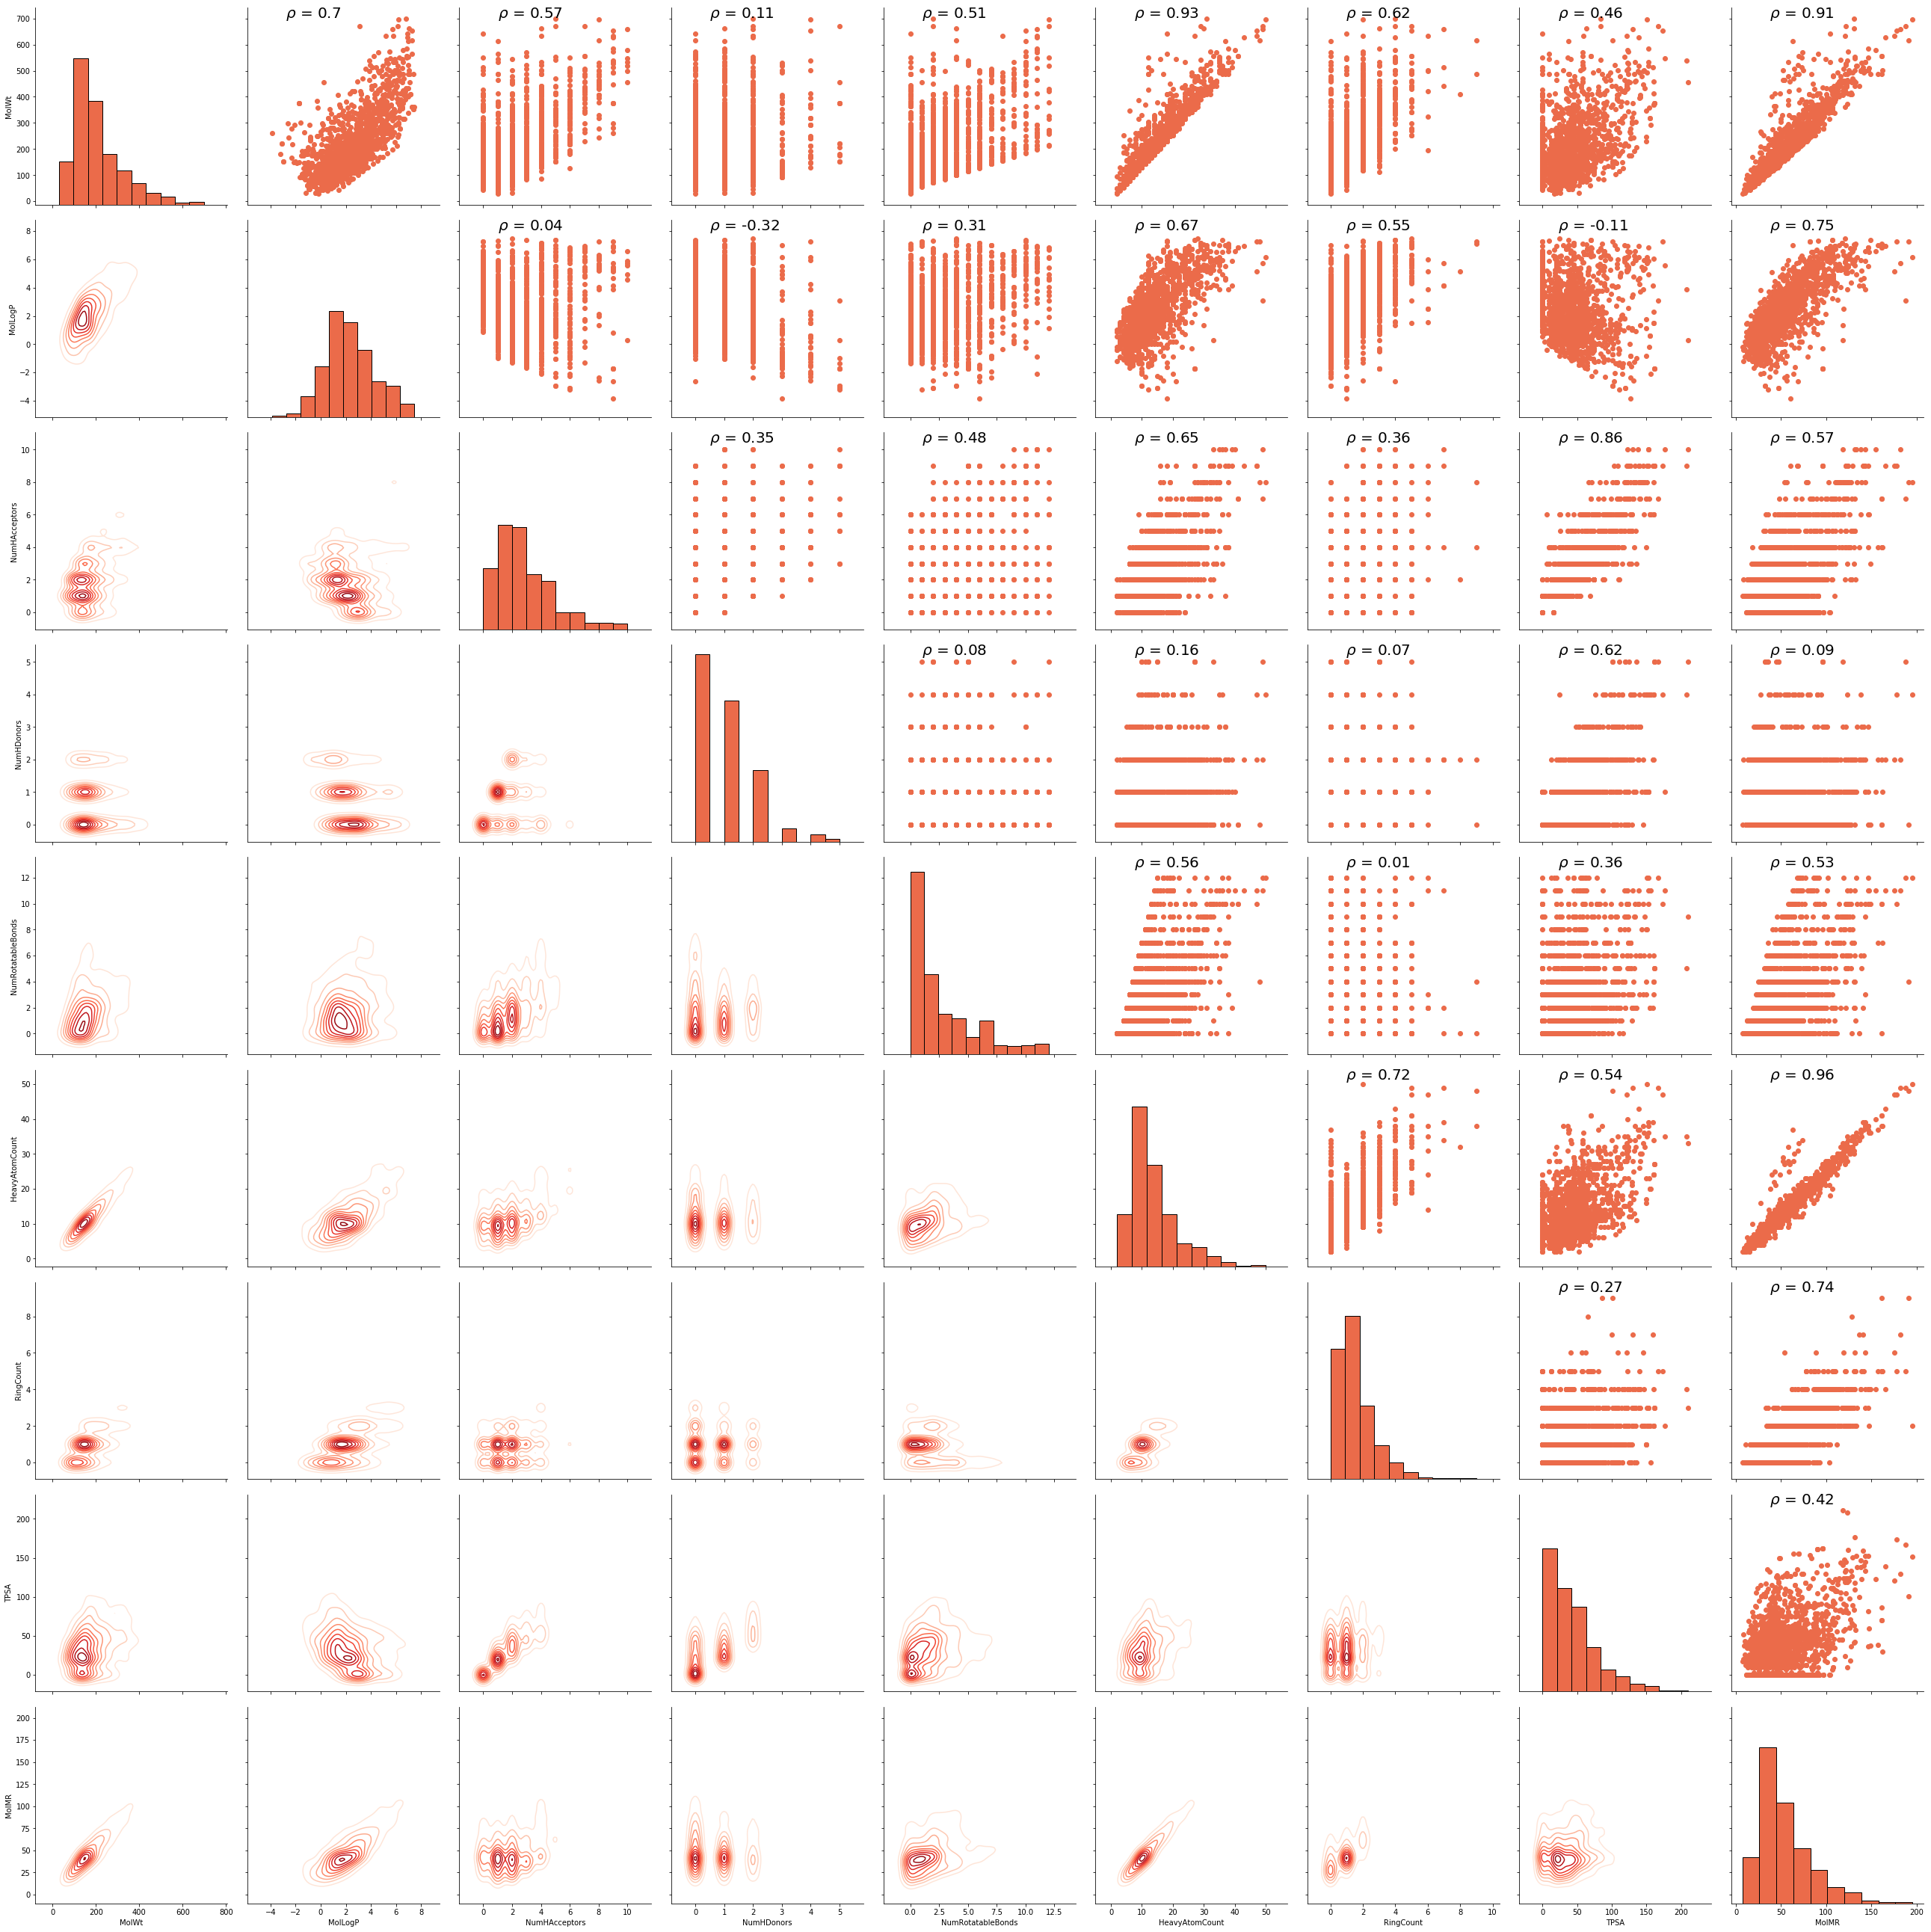

In [15]:
# sns.pairplot(dfFiltered, 
#              vars = ['MolWt', 'MolLogP', 'NumHAcceptors', 'NumHDonors', 'NumRotatableBonds', \
#                  'HeavyAtomCount', 'RingCount', 'TPSA', 'MolMR'], 
#              hue = 'EndPt', diag_kind = 'kde', 
#              plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
#              height = 4);
# # Title 
# plt.suptitle('Pair Plot', 
#              size = 28);

# Create a pair grid instance
grid = sns.PairGrid(data = dfFiltered,
                    vars = ['MolWt', 'MolLogP', 'NumHAcceptors', 'NumHDonors', 'NumRotatableBonds', \
                            'HeavyAtomCount', 'RingCount', 'TPSA', 'MolMR'],
                    height = 4)

# Map the plots to the locations
grid = grid.map_upper(plt.scatter, color = '#eb6b4a')
grid = grid.map_upper(corr)
grid = grid.map_lower(sns.kdeplot, cmap = 'Reds')
grid = grid.map_diag(plt.hist, bins = 10, edgecolor =  'k', color = '#eb6b4a');

# Build training set & test set

In [16]:
train, test = train_test_split(dfFiltered, test_size = 0.2, random_state = 42,
                               stratify=dfFiltered[['ReadyBiodeg']])
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

# X & y

In [17]:
X_train = train.drop(columns=['SMILES', 'EndPt', 'InChI', 'ReadyBiodeg'])
X_test = test.drop(columns=['SMILES', 'EndPt', 'InChI', 'ReadyBiodeg'])
y_train = np.ravel(train[['ReadyBiodeg']])
y_test = np.ravel(test[['ReadyBiodeg']])

In [18]:
print(X_train.shape)
print(X_test.shape)
print(len(y_train))
print(len(y_test))

(1441, 200)
(361, 200)
1441
361


# Feature Engineering

## Identify / remove near-zero variance descriptors

In [19]:
def variance_threshold_selector(data, threshold = 0.5):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices = True)]]

nzv = variance_threshold_selector(X_train, 0.0)

X_train = X_train[nzv.columns]
X_test = X_test[nzv.columns]

In [20]:
print(X_train.shape)
print(X_test.shape)

(1441, 182)
(361, 182)


## Identify / remove highly correlated descriptors

In [21]:
corr_matrix = X_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),
                                  k = 1).astype(np.bool))
to_drop = [column for column in upper.columns
           if any(upper[column] > 0.85)]

X_train = X_train[X_train.columns.drop(to_drop)]
X_test = X_test[X_test.columns.drop(to_drop)]

In [22]:
print(X_train.shape)
print(X_test.shape)

(1441, 135)
(361, 135)


In [23]:
list(X_train.columns);

## Standardize features by removing the mean and scaling to unit variance

In [24]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

## Feature Selection: recursive feature elimination with cross validation

In [25]:
from sklearn.feature_selection import RFECV
estimator = RandomForestClassifier(random_state = 42)
selector = RFECV(estimator, step = 1, cv = 5)
selector = selector.fit(X_train_std, y_train)

X_train_occam = X_train_std[:, selector.support_]
X_test_occam = X_test_std[:, selector.support_]

print(X_train_occam.shape)
print(X_test_occam.shape)

(1441, 91)
(361, 91)


# Models

## Random Forest Classification

In [69]:
rf = RandomForestClassifier(random_state = 42)

##### Look at parameters used by our current forest

In [70]:
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [73]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 11)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

##### Create the random grid

In [74]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 140, 180, 220, 260, 300, 340, 380, 420, 460, 500]}


##### Use the random grid to search for the best hyperparameters

In [75]:
# First create the base model to tune
rf = RandomForestClassifier(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                              n_iter = 100, scoring = 'neg_mean_absolute_error', 
                              cv = 3, verbose = 2, random_state = 42,
                              n_jobs = -1, return_train_score = True)

##### Fit the random search model

In [124]:
rf_random.fit(X_train_occam, y_train);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.0min finished


In [125]:
rf_random.best_params_

{'bootstrap': False,
 'max_depth': 40,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 380}

In [126]:
import pickle
f = open('RandomForest.pkl', 'wb')
pickle.dump(rf_random, f)
f.close()

In [127]:
pred = rf_random.predict(X_test_occam)

In [128]:
kappa = metrics.cohen_kappa_score(y_test, pred)
print('Kappa: {:.2f}'.format(kappa))

Kappa: 0.61


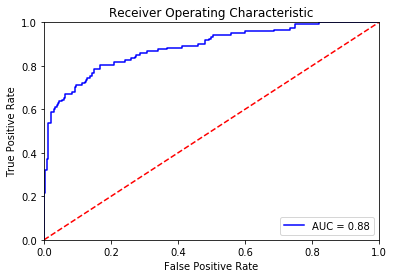

In [129]:
probs = rf_random.predict_proba(X_test_occam)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [130]:
print(confusion_matrix(y_test, pred))

[[218  22]
 [ 38  83]]


In [131]:
rf_random.best_params_

{'bootstrap': False,
 'max_depth': 40,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 380}

In [132]:
col_names =  ['TrueLabel', 'Nomine', 'Probability']
plotDF  = pd.DataFrame(columns = col_names)

In [133]:
plotDF['TrueLabel'] = y_test
plotDF['Nomine'] = 'Prediction'
plotDF['Probability'] = preds

In [134]:
plotDF.head()

,TrueLabel,Nomine,Probability
0,0,Prediction,0.021125
1,0,Prediction,0.320927
2,1,Prediction,0.881180
3,0,Prediction,0.181746
4,0,Prediction,0.052895


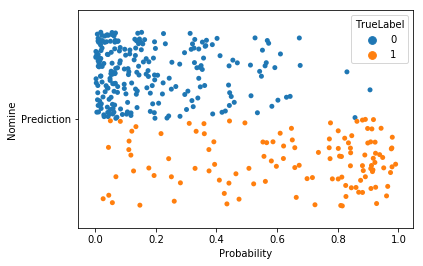

In [135]:
confusionPlot = sns.stripplot(x = 'Probability', y = 'Nomine', hue = 'TrueLabel', \
                             jitter = 0.4, dodge = True, data = plotDF)

## Support Vector Classification

In [136]:
svm = SVC()

In [137]:
pprint(svm.get_params())

{'C': 1.0,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto_deprecated',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


In [138]:
best_kappa_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # train an SVC for each combination of gamma and C
        svm = SVC(gamma = gamma, C = C)
        svm.fit(X_train_occam, y_train)
        pred = svm.predict(X_test_occam)
        # evaluate the SVC on the test set
        kappa = metrics.cohen_kappa_score(y_test, pred)
        # better kappa? store kappa and parameters
        if kappa > best_kappa_score:
            best_kappa_score = kappa
            best_parameters = {'C' : C, 'gamma' : gamma}
            
print("Best score: {:.2f}".format(best_kappa_score))
print("Best parameters: {}".format(best_parameters)) 

Best score: 0.65
Best parameters: {'C': 1, 'gamma': 0.01}


In [140]:
svm = SVC(C = 100, gamma = 0.1, kernel = 'rbf', probability = True)
svm.fit(X_train_occam, y_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [141]:
import pickle
f = open('SupportVectorMachine.pkl', 'wb')
pickle.dump(svm, f)
f.close()

In [142]:
pred_svm = svm.predict(X_test_occam)

In [143]:
kappa = metrics.cohen_kappa_score(y_test, pred_svm)
print('Kappa: {:.2f}'.format(kappa))

Kappa: 0.50


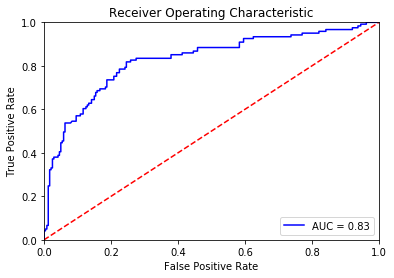

In [144]:
probs_svm = svm.predict_proba(X_test_occam)
preds_svm = probs_svm[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds_svm)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [145]:
print(confusion_matrix(y_test, pred_svm))

[[220  20]
 [ 55  66]]


In [146]:
col_names =  ['TrueLabel', 'Nomine', 'Probability']
plotDF  = pd.DataFrame(columns = col_names)

In [147]:
plotDF['TrueLabel'] = y_test
plotDF['Nomine'] = 'Prediction'
plotDF['Probability'] = preds_svm

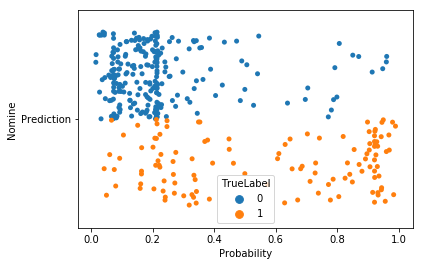

In [148]:
confusionPlot = sns.stripplot(x = 'Probability', y = 'Nomine', hue = 'TrueLabel', \
                             jitter = 0.4, dodge = True, data = plotDF)

## Logistic Regression

In [149]:
lr = LogisticRegression()

In [150]:
pprint(lr.get_params())

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'warn',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


In [151]:
best_kappa_score = 0

for C in [0.001, 0.01, 0.1, 1, 10, 100]:
    # train logistic regression for each value of C
    lr = LogisticRegression(C = C)
    lr.fit(X_train_occam, y_train)
    pred_lr = lr.predict(X_test_occam)
    # evaluate the lr on the test set
    kappa = metrics.cohen_kappa_score(y_test, pred)
    # better kappa? store kappa and parameters
    if kappa > best_kappa_score:
        best_kappa_score = kappa
        best_parameters = {'C' : C}
            
print("Best score: {:.2f}".format(best_kappa_score))
print("Best parameters: {}".format(best_parameters)) 

Best score: 0.06
Best parameters: {'C': 0.001}


In [152]:
lr = LogisticRegression(C = 0.001)
lr.fit(X_train_occam, y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [153]:
import pickle
f = open('LogisticRegressionj.pkl', 'wb')
pickle.dump(lr, f)
f.close()

In [154]:
kappa = metrics.cohen_kappa_score(y_test, pred_lr)
print('Kappa: {:.2f}'.format(kappa))

Kappa: 0.63


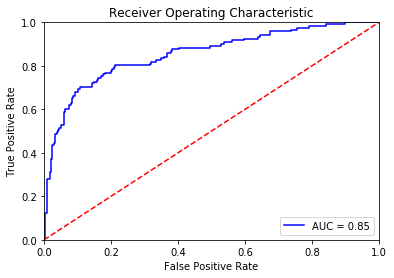

In [155]:
probs_lr = lr.predict_proba(X_test_occam)
preds_lr = probs_lr[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds_lr)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [156]:
print(confusion_matrix(y_test, pred_lr))

[[216  24]
 [ 34  87]]


In [157]:
col_names =  ['TrueLabel', 'Nomine', 'Probability']
plotDF  = pd.DataFrame(columns = col_names)

In [158]:
plotDF['TrueLabel'] = y_test
plotDF['Nomine'] = 'Prediction'
plotDF['Probability'] = preds_lr

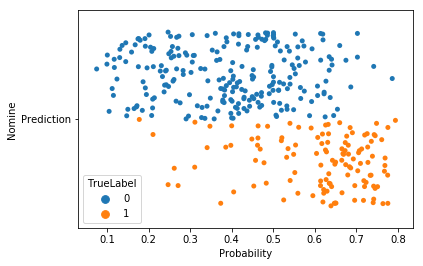

In [159]:
confusionPlot = sns.stripplot(x = 'Probability', y = 'Nomine', hue = 'TrueLabel', \
                             jitter = 0.4, dodge = True, data = plotDF)

## Gaussian naive Bayes

In [160]:
# Create a Gaussian Classifier
gnb = GaussianNB()

In [161]:
pprint(gnb.get_params())

{'priors': None, 'var_smoothing': 1e-09}


In [162]:
# Train the model using the training sets 
gnb.fit(X_train_occam, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [163]:
pred_gnb = gnb.predict(X_test_occam)

In [164]:
kappa = metrics.cohen_kappa_score(y_test, pred_gnb)
print('Kappa: {:.2f}'.format(kappa))

Kappa: 0.39


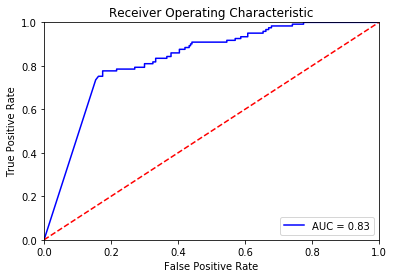

In [165]:
probs_gnb = gnb.predict_proba(X_test_occam)
preds_gnb = probs_gnb[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds_gnb)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [166]:
print(confusion_matrix(y_test, pred_gnb))

[[138 102]
 [ 14 107]]


In [167]:
col_names =  ['TrueLabel', 'Nomine', 'Probability']
plotDF  = pd.DataFrame(columns = col_names)

In [168]:
plotDF['TrueLabel'] = y_test
plotDF['Nomine'] = 'Prediction'
plotDF['Probability'] = preds_gnb

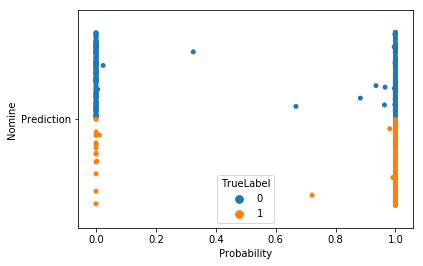

In [169]:
confusionPlot = sns.stripplot(x = 'Probability', y = 'Nomine', hue = 'TrueLabel', \
                             jitter = 0.4, dodge = True, data = plotDF)

## AdaBoost

In [170]:
from sklearn.ensemble import AdaBoostClassifier

In [172]:
# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)
# Train Adaboost Classifer
abc.fit(X_train_occam, y_train)

#Predict the response for test dataset
pred_abc = abc.predict(X_test_occam)

In [173]:
kappa = metrics.cohen_kappa_score(y_test, pred_abc)
print('Kappa: {:.2f}'.format(kappa))

Kappa: 0.53


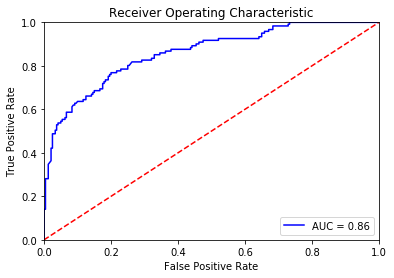

In [174]:
probs_abc = abc.predict_proba(X_test_occam)
preds_abc = probs_abc[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds_abc)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [175]:
print(confusion_matrix(y_test, pred_abc))

[[207  33]
 [ 41  80]]


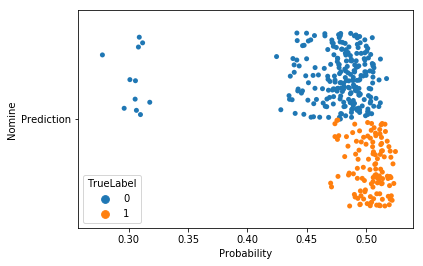

In [176]:
col_names =  ['TrueLabel', 'Nomine', 'Probability']
plotDF  = pd.DataFrame(columns = col_names)

plotDF['TrueLabel'] = y_test
plotDF['Nomine'] = 'Prediction'
plotDF['Probability'] = preds_abc

confusionPlot = sns.stripplot(x = 'Probability', y = 'Nomine', hue = 'TrueLabel', \
                             jitter = 0.4, dodge = True, data = plotDF)

In [177]:
svc = SVC(probability=True, kernel = 'rbf')
abc = AdaBoostClassifier(n_estimators = 50, base_estimator = svc, learning_rate = 1)

# Train Adaboost Classifer
abc.fit(X_train_occam, y_train)

#Predict the response for test dataset
pred_abc = abc.predict(X_test_occam)

In [178]:
kappa = metrics.cohen_kappa_score(y_test, pred_abc)
print('Kappa: {:.2f}'.format(kappa))

Kappa: 0.17


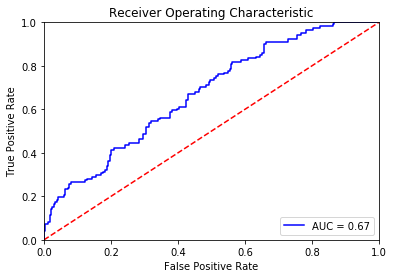

In [179]:
probs_abc = abc.predict_proba(X_test_occam)
preds_abc = probs_abc[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds_abc)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [180]:
print(confusion_matrix(y_test, pred_abc))

[[210  30]
 [ 88  33]]


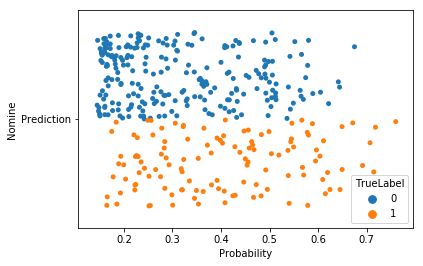

In [181]:
col_names =  ['TrueLabel', 'Nomine', 'Probability']
plotDF  = pd.DataFrame(columns = col_names)

plotDF['TrueLabel'] = y_test
plotDF['Nomine'] = 'Prediction'
plotDF['Probability'] = preds_abc

confusionPlot = sns.stripplot(x = 'Probability', y = 'Nomine', hue = 'TrueLabel', \
                             jitter = 0.4, dodge = True, data = plotDF)

# Applicability Domain

## Projections

### PCA

In [182]:
pca = PCA(n_components=2)
pca.fit(X_train_occam)
train_projected = pd.DataFrame(pca.transform(X_train_occam))
test_projected = pd.DataFrame(pca.transform(X_test_occam))

In [183]:
print(X_train_occam.shape)

(1441, 91)


In [184]:
print(train_projected.shape)

(1441, 2)


In [185]:
col_names =  ['PC1', 'PC2', 'Set']
trainPCAplot  = pd.DataFrame(columns = col_names)
testPCAplot  = pd.DataFrame(columns = col_names)

trainPCAplot['PC1'] = train_projected[0]
trainPCAplot['PC2'] = train_projected[1]
trainPCAplot['Set'] = 'train'

testPCAplot['PC1'] = test_projected[0]
testPCAplot['PC2'] = test_projected[1]
testPCAplot['Set'] = 'test'

result = pd.concat([trainPCAplot, testPCAplot])

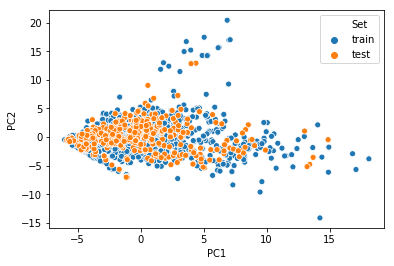

In [186]:
sns.scatterplot(x = 'PC1', y = 'PC2', hue = 'Set', data = result)

### t-SNE
t-distributed Stochastic Neighbor Embedding

In [187]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne.fit(X_train_occam)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1441 samples in 0.019s...
[t-SNE] Computed neighbors for 1441 samples in 0.431s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1441
[t-SNE] Computed conditional probabilities for sample 1441 / 1441
[t-SNE] Mean sigma: 3.221874
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.737045
[t-SNE] KL divergence after 300 iterations: 1.170466


TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=2, n_iter=300, n_iter_without_progress=300, perplexity=40,
   random_state=None, verbose=1)

In [188]:
train_projected = pd.DataFrame(tsne.fit_transform(X_train_occam))
test_projected = pd.DataFrame(tsne.fit_transform(X_test_occam))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1441 samples in 0.009s...
[t-SNE] Computed neighbors for 1441 samples in 0.445s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1441
[t-SNE] Computed conditional probabilities for sample 1441 / 1441
[t-SNE] Mean sigma: 3.221874
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.730026
[t-SNE] KL divergence after 300 iterations: 1.205183
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 361 samples in 0.002s...
[t-SNE] Computed neighbors for 361 samples in 0.030s...
[t-SNE] Computed conditional probabilities for sample 361 / 361
[t-SNE] Mean sigma: 3.678520
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.314972
[t-SNE] KL divergence after 300 iterations: 0.967822


In [189]:
col_names =  ['PC1', 'PC2', 'Set']
trainPCAplot  = pd.DataFrame(columns = col_names)
testPCAplot  = pd.DataFrame(columns = col_names)

trainPCAplot['PC1'] = train_projected[0]
trainPCAplot['PC2'] = train_projected[1]
trainPCAplot['Set'] = 'train'

testPCAplot['PC1'] = test_projected[0]
testPCAplot['PC2'] = test_projected[1]
testPCAplot['Set'] = 'test'

result = pd.concat([trainPCAplot, testPCAplot])

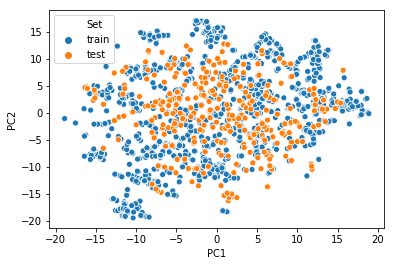

In [190]:
sns.scatterplot(x = 'PC1', y = 'PC2', hue = 'Set', data = result)

### MDS

In [191]:
mds = MDS(n_components=2)
mds.fit(X_train_occam)

MDS(dissimilarity='euclidean', eps=0.001, max_iter=300, metric=True,
  n_components=2, n_init=4, n_jobs=None, random_state=None, verbose=0)

In [192]:
train_projected = pd.DataFrame(mds.fit_transform(X_train_occam))
test_projected = pd.DataFrame(mds.fit_transform(X_test_occam))

In [193]:
col_names =  ['PC1', 'PC2', 'Set']
trainPCAplot  = pd.DataFrame(columns = col_names)
testPCAplot  = pd.DataFrame(columns = col_names)

trainPCAplot['PC1'] = train_projected[0]
trainPCAplot['PC2'] = train_projected[1]
trainPCAplot['Set'] = 'train'

testPCAplot['PC1'] = test_projected[0]
testPCAplot['PC2'] = test_projected[1]
testPCAplot['Set'] = 'test'

result = pd.concat([trainPCAplot, testPCAplot])

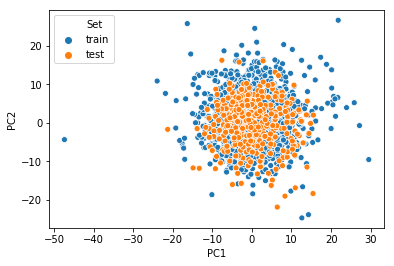

In [194]:
sns.scatterplot(x = 'PC1', y = 'PC2', hue = 'Set', data = result)